演示了从存储在磁盘上的纯文本文件开始的文本分类。将训练一个二元分类器对 IMDB 数据集执行情感分析。
https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/text_classification.ipynb

In [31]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

### 获取数据集

In [33]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [45]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [46]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

aclImdb/train/pos 和 aclImdb/train/neg 目录包含许多文本文件，每个文件都是一条电影评论。来看看其中的一条评论

In [47]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 加载数据集

要准备用于二元分类的数据集，磁盘上需要有两个文件夹，分别对应于 class_a 和 class_b。这些将是正面和负面的电影评论，可以在 aclImdb/train/pos 和 aclImdb/train/neg 中找到。由于 IMDB 数据集包含其他文件夹，因此您需要在使用此实用工具之前将其移除。

In [48]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '.\\aclImdb\\train\\unsup'

IMDB 数据集已经分成训练集和测试集，但缺少验证集。我们来通过下面的 validation_split 参数，使用 80:20 拆分训练数据来创建验证集。

In [49]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


查看数据集样本

In [50]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

查看数据集上的 class_names 属性

In [51]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [52]:
# 验证数据集
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [53]:
# 测试数据集
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 准备数据集

使用 tf.keras.layers.TextVectorization 层对数据进行标准化、词例化和向量化
- 标准化： 通常是移除标点符号或 HTML 元素以简化数据集
- 词例化：是指将字符串分割成词例（例如，通过空格将句子分割成单个单词）
- 向量化：是指将词例转换为数字

In [54]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

ValueError: Custom>custom_standardization has already been registered to <function custom_standardization at 0x0000024634E47550>

接下来，您将创建一个 TextVectorization 层。您将使用该层对我们的数据进行标准化、词例化和向量化。您将 output_mode 设置为 int 以便为每个词例创建唯一的整数索引。

请注意，您使用的是默认拆分函数，以及您在上面定义的自定义标准化函数。您还将为模型定义一些常量，例如显式的最大 sequence_length，这会使层将序列填充或截断为精确的 sequence_length 值。

In [55]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

接下来，您将调用 adapt 以使预处理层的状态适合数据集。这会使模型构建字符串到整数的索引。

In [56]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

创建一个函数来查看使用该层预处理一些数据的结果

In [57]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [58]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [59]:
print("86 ---> ",vectorize_layer.get_vocabulary()[86])
print(" 17 ---> ",vectorize_layer.get_vocabulary()[17])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

86 --->  great
 17 --->  movie
Vocabulary size: 10000


作为最后的预处理步骤，将之前创建的 TextVectorization 层应用于训练数据集、验证数据集和测试数据集

In [60]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

从磁盘加载后，.cache() 会将数据保存在内存中。这将确保数据集在训练模型时不会成为瓶颈。如果您的数据集太大而无法放入内存，也可以使用此方法创建高性能的磁盘缓存，这比许多小文件的读取效率更高。

prefetch() 会在训练时将数据预处理和模型执行重叠。

In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 创建模型

In [62]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

In [63]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 训练模型

In [64]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.6644 - binary_accuracy: 0.6956 - val_loss: 0.6170 - val_binary_accuracy: 0.7722
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5511 - binary_accuracy: 0.8011 - val_loss: 0.5006 - val_binary_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4463 - binary_accuracy: 0.8450 - val_loss: 0.4218 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3796 - binary_accuracy: 0.8643 - val_loss: 0.3748 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3359 - binary_accuracy: 0.8791 - val_loss: 0.3458 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3056 - binary_accuracy: 0.8886 - val_loss: 0.3264 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

### 评估模型

In [65]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3105 - binary_accuracy: 0.8726
Loss:  0.31054967641830444
Accuracy:  0.8726400136947632


绘制训练曲线

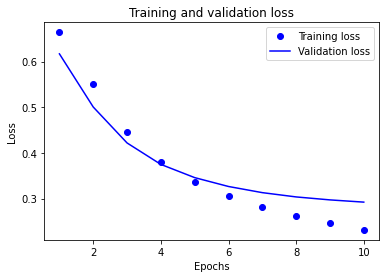

In [66]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

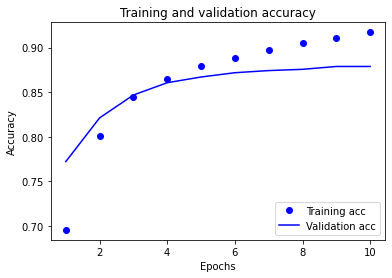

In [67]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### 导出模型

在上面的代码中，您在向模型馈送文本之前对数据集应用了 TextVectorization。 如果您想让模型能够处理原始字符串（例如，为了简化部署），您可以在模型中包含 TextVectorization 层。为此，您可以使用刚刚训练的权重创建一个新模型。

In [68]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.summary()

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 160033    
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
782/782 [==============================] - 5s 5ms/step - loss: 0.3105 - accuracy: 0.8726
0.8726400136947632


In [69]:
export_model.save('saved_model/imdb_model')

INFO:tensorflow:Assets written to: saved_model/imdb_model\assets


In [70]:
new_model = tf.keras.models.load_model('saved_model/imdb_model')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 160033    
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### 预测

In [71]:
examples = ["The movie was great!", "The movie was bad!"]

new_model.predict(examples)

1/1 [==============================] - 0s 92ms/step


array([[0.6029948],
       [0.3475852]], dtype=float32)